# Visualisation Generation Scripts

1. Run the first 5 cells in the notebook to set everything up
2. Scroll to the bottom and follow the instructions you find there...

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import svgwrite
import base64
from lxml import etree
from shapely.geometry import LineString
from shapely.geometry import Point
import math
from geomdl import BSpline
from geomdl import utilities
import numpy as np
from IPython.display import display_svg, SVG
from wand.image import Image

In [2]:
!pip install svglib

You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
def calculate_edge_offset(line_start, line_end, node_size):
    """Calculate where to start an edge, factoring in the size of the node with which it connects"""
    node_size = int(node_size)
    p = Point(line_end)
    c = p.buffer(node_size + 8).boundary
    l = LineString([(line_start), (line_end)])
    i = c.intersection(l)

    try:
        return i.coords[0]
    except:
        return p.coords[0]


def angle_between_points(a, b):
    """Find the angle between two points on the basis of their coordinates"""
    deltaY = b[1] - a[1]
    deltaX = b[0] - a[0]

    return math.atan2(deltaY, deltaX)


def calculate_control_points(start, end):
    """Calculate the control points for a curved line from the intersection of two circles centered on the start and end points"""

    length = math.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    p1 = Point(start[0], start[1])
    p2 = Point(end[0], end[1])

    multiplier = 0.6
    
    c1 = p1.buffer(length * multiplier).boundary
    c2 = p2.buffer(length * multiplier).boundary
    i = c1.intersection(c2)
    
    if len(i) > 0:
        return (i[0].coords[0], i[1].coords[0])
    else:
        return (start, end)


def draw_curved_path(dwg, start, end, edge_style):
    """Draw a curved path in a given style"""
    start_str = str(start[0]) + ',' + str(start[1])
    end_str = str(end[0]) + ',' + str(end[1])

    case = None

    if edge_style['stroke-case'] > 0:
        if edge_style['stroke-dasharray'] is not None:    
            case = dwg.path(
                d='M' + start_str,
                stroke=edge_style['stroke-case-color'],
                fill='none',
                stroke_width=edge_style['stroke-case'],
                stroke_dasharray=edge_style['stroke-dasharray']
            )
        else:
            case = dwg.path(
                d='M' + start_str,
                fill='none',
                stroke=edge_style['stroke-case-color'],
                stroke_width=edge_style['stroke-case'],
            )


    if edge_style['stroke-dasharray'] is not None:
        path = dwg.path(
            d='M' + start_str, 
            stroke=edge_style['stroke'],
            fill='none',
            stroke_dasharray=edge_style['stroke-dasharray'],
            stroke_width=edge_style['stroke-width']
        )
    else:
        path = dwg.path(
            d='M' + start_str, 
            stroke=edge_style['stroke'],
            fill='none',
            stroke_width=edge_style['stroke-width']
        )

    control_points = calculate_control_points(start, end)

    if (start[0] > end[0]):
        control = str(control_points[0][0]) + ', ' + str(control_points[0][1])
    else:
        control = str(control_points[1][0]) + ', ' + str(control_points[1][1])

    path.push('Q' + control + ' ' + end_str)

    if case:
        case.push('Q' + control + ' ' + end_str)
        return path, case
    else:
        return path




def arrowhead(start_x, start_y, end_x, end_y, r):
    """Draw the head of an arrow. Took forever, but adapted the solution from here: https://stackoverflow.com/questions/808826/draw-arrow-on-canvas-tag/36805543#36805543"""
    x_center = end_x
    y_center = end_y

    angle = math.atan2(end_y - start_y, end_x - start_x)
    a = (r * math.cos(angle) + x_center, r * math.sin(angle) + y_center)

    angle += (1/3)*(2*math.pi)
    b = (r * math.cos(angle) + x_center, r * math.sin(angle) + y_center)

    angle += (1/3)*(2*math.pi)
    c = (r * math.cos(angle) + x_center, r * math.sin(angle) + y_center)

    return [a, b, c]



class SvgGrapher:
    """A class for generating custom-styled SVG renders of chrontopic cartographies graphml files"""

    def __init__(self, input_file):
        """
        Input file: path to a graphml file
        """

        tree = etree.parse(input_file)
        root = tree.getroot()


        # Parse the graph attributes from the key 

        self.key = {}

        for key_item in root.iter('{http://graphml.graphdrawing.org/xmlns}key'):
            values = key_item.values()
            self.key[values[3]] = {'name': values[0], 'type': values[1], 'for': values[2]}


        # Parse the nodes, matching up the key values to the data attributes

        self.nodes = {}

        for node in root.iter('{http://graphml.graphdrawing.org/xmlns}node'):
            node_data = {}
            for data in node:
                key_item = data.attrib['key']
                
                node_data[key_item] = data.text

            self.nodes[node.attrib['id']] = node_data
                

        # Parse the edges, matching up the key values to the data attributes and adding 'x' and 'y' coordinates from the node data

        self.edges = {}

        for edge in root.iter('{http://graphml.graphdrawing.org/xmlns}edge'):
            edge_data = {
            }
            edge_data['source'] = edge.attrib['source']
            edge_data['target'] = edge.attrib['target']
            for data in edge:
                key_item = data.attrib['key']
                edge_data[key_item] = data.text
        
            self.edges[edge.attrib['id']] = edge_data

        # Find the coordinates of each source and target

        for edge, data in self.edges.items():
            source = data['source']
            target = data['target']

            self.edges[edge]['start'] = (self.nodes[source]['x'], self.nodes[source]['y'])
            self.edges[edge]['end'] = (self.nodes[target]['x'], self.nodes[target]['y'])


    def print_key(self):
        print(self.key.keys())

    def print_nodes(self):
        print(self.nodes.keys())
        print(self.nodes.values())

    def print_edges(self):
        print(self.edges.keys())

    def draw_edge(edge_style, curved=False):
        """
        Draws an edge
        """

    # define blend modes
        

    def draw_graph(self, output_file, style, size=1.0, scale_correction=900, curved=False, symbology=True, label_correction=1.0, node_scale=5, offset=(0,0)):
        """
        output_file: path to an svg file
        style: a python dictionary defining the styles for nodes and edges
        size: default size is 2000 * 2000 multiplied by the size value
        scale_correction: change this value to alter the size of the graph relative to the total size of the svg canvas
        curved: whether edge connections are curved or not
        symbology: whether or not to use symbology when drawing the graph or a colour scheme
        label_correction: adjusts the position of the labels relative to the centre of the nodes
        node_scale: the size of the nodes relative to canvas
        offset: x y coordinates to offset the centre of the graph - useful when using a background image (as defined in the style)
        """

        dwg_size = (2000 * size, 2000 * size)

        dwg = svgwrite.Drawing(filename=output_file, size=dwg_size, profile='full', debug=True)
        
        rect = dwg.rect(insert=(0,0), size=dwg_size, fill=style['background']['color'])
        
        dwg.add(rect)

        if style['background'].get('image') is not None: 
            #with open(style['background']['image'], 'rb') as file:
            #    f = dwg.defs.add(dwg.filter(id="multiply", x=0, y=0, width="100%", height="100%"))
            #    f.feFlood(x=0, y=0, width="100%", height="100%", result='flood', flood_color=style['background']['color'])
            #    f.feBlend(in_="flood", in2="SourceGraphic", mode="multiply")
            #    
            #    img = file.read()
            #    encoded = base64.b64encode(img).decode()
            #    svgdata = 'data:image/svg+xml;base64,{}'.format(encoded)
            #    image = dwg.add(dwg.image(href=svgdata, insert=(0, 0), size=dwg_size, filter="url(#multiply)", opacity=style['background']['opacity']))
            path = style['background'].get('image')
            img = Image(filename=path)
            img_data = img.make_blob(format='png')
            encoded = base64.b64encode(img_data).decode()
            png_data = 'data:image/png;base64,{}'.format(encoded)
            image = dwg.add(dwg.image(href=(png_data), insert=(0,0), size=dwg_size, opacity=style['background']['opacity']))
            

        ## Scale the graph to fit the svg canvas

        # First, find the bounds of the graph

        maxX = 0
        maxY = 0
        minX = 0
        minY = 0

        for node, data in self.nodes.items():
            x = float(data['x'])
            y = float(data['y'])
            if (maxX == 0 and maxY == 0 and minX == 0 and minY == 0):
                maxX = x
                maxY = y
                minX = x
                minY = y
            if x > maxX:
                maxX = x
            if y > maxY:
                maxY = y
            if x < minX:
                minX = x
            if y < minY:
                minY = y

        scale = (max(scale_correction / maxX, scale_correction / maxY)) * size

        # Then calculate the transformation to fit the nodes on the canvas
        
        for node, data in self.nodes.items():
            # Translate and scale nodes
            x = float(data['x'])
            y = float(data['y'])
            
            x -= (maxX + minX) / 2
            y -= (maxY + minY) / 2

            x *= scale
            y *= scale

            x += 1050 * size
            y += 1050 * size

            y = (2050 * size) - y 

            # Store translated coordinates, with x,y offset

            data['x'] = x + offset[0]
            data['y'] = y + offset[1]


        ## Draw the edges

        edges_group = dwg.add(dwg.g())

        for edge, data in self.edges.items():
        
            # Pull out the sources and targets

            source = data['source']
            target = data['target']

            # Find the coordinates of each source and target

            start = (self.nodes[source]['x'], self.nodes[source]['y'])
            end = (self.nodes[target]['x'], self.nodes[target]['y'])
            
            # Shorten the line so it doesn't overlap the symbol

            source_size = ((float(self.nodes[source]['size']) * 5) / 2) * size
            target_size = ((float(self.nodes[target]['size']) * 5) / 2) * size

            edge_style = None
            
            # First set the edge style to the default of 'None', so if there isn't a connection type a line is still drawn
            for es in style['edges']:
                if es['label'] == None:
                    edge_style = es
            
            # Then go over the connections again and if there is a matching connection type, set that as the edge_style
            for es in style['edges']:
                for v in data.values():
                    if es['label'] == v:
                        edge_style = es
                        break
                    
            if curved == False:
                if edge_style['stroke-case'] > 0:
                    if edge_style['stroke-dasharray'] is None:    
                        edges_group.add(dwg.line(
                            start=start,
                            end=end,
                            stroke=edge_style['stroke-case-color'],
                            stroke_width=edge_style['stroke-case']
                        ))
                    else:
                        edges_group.add(dwg.line(
                            start=start,
                            end=end,
                            stroke=edge_style['stroke-case-color'],
                            stroke_width=edge_style['stroke-case'],
                            stroke_dasharray=edge_style['stroke-dasharray']
                        ))

                if edge_style['stroke-dasharray'] is None:
                    edges_group.add(dwg.line(
                            start=start,
                            end=end,
                            stroke=edge_style['stroke'],
                            stroke_width=edge_style['stroke-width']
                        ))
                else:
                    edges_group.add(dwg.line(
                            start=start,
                            end=end,
                            stroke=edge_style['stroke'],
                            stroke_width=edge_style['stroke-width'],
                            stroke_dasharray=edge_style['stroke-dasharray']
                        ))

                arrowhead_size = 5 * size

                offset = calculate_edge_offset(start, end, target_size)

                arrowhead_geom = arrowhead(start[0], start[1], offset[0], offset[1], r=arrowhead_size)

                if edge_style['stroke-case'] > 0:
                    fill = edge_style['stroke-case-color']
                else:
                    fill = edge_style['stroke']

                edges_group.add(dwg.polygon(arrowhead_geom, fill=fill))


            else:
                path = draw_curved_path(dwg, start, end, edge_style)
                if edge_style['stroke-case'] > 0:
                    edges_group.add(path[1])
                    edges_group.add(path[0])
                else:
                    edges_group.add(path)


                # Calculate arrowhead angle

                angle = angle_between_points(start, end)

                control_points = calculate_control_points(start, end)

                arrowhead_size = 5 * size

                crv = BSpline.Curve()

                crv.degree = 2

                if (start[0] > end[0]):
                    crv.ctrlpts = [start, control_points[0], end]
                else:
                    crv.ctrlpts = [start, control_points[1], end]

                crv.knotvector = utilities.generate_knot_vector(crv.degree, len(crv.ctrlpts))

                crv.delta = 0.05

                curve_points = crv.evalpts

                l = LineString(curve_points)

                p = Point(end[0], end[1])
                print(target_size)
                c = p.buffer(target_size).boundary
                i = c.intersection(l)

                # If the nodes are too close together, i sometimes returns empty, therefore don't draw the arrowhead
                try:
                    if (start[0] > end[0]):
                        arrowhead_geom = arrowhead(control_points[0][0], control_points[0][1], i.coords[0][0], i.coords[0][1], r=arrowhead_size)
                    else:
                        arrowhead_geom = arrowhead(control_points[1][0], control_points[1][1], i.coords[0][0], i.coords[0][1], r=arrowhead_size)
                except:
                    pass


                #offset = calculate_edge_offset(start, end, target_size)

                #if (start[0] > end[0]):
                #    arrowhead_geom = arrowhead(control_points[0][0], control_points[0][1], offset[0], offset[1], r=arrowhead_size)
                #else:
                #    arrowhead_geom = arrowhead(control_points[1][0], control_points[1][1], offset[0], offset[1], r=arrowhead_size)

                if edge_style['stroke-case'] > 0:
                    fill = edge_style['stroke-case-color']
                else:
                    fill = edge_style['stroke']

                edges_group.add(dwg.polygon(arrowhead_geom, fill=fill))


        ## Now draw the nodes

        nodes_group = dwg.add(dwg.g())

        for node, data in self.nodes.items():
            x = data['x']
            y = data['y']
            node_size = (node_scale * (float(data['size']) * size), node_scale * (float(data['size'])) * size)

            circle = nodes_group.add(dwg.circle(stroke='none', fill=style['background']['color'], center=(x,y), r=node_size[0]/2))

            # Get the symbology or colour scheme
            for node_style in style['nodes']:
                for v in data.values():
                    if node_style['label'] == v:
                        with open(node_style['symbol'], 'rb') as file:
                            img = file.read()
                            encoded = base64.b64encode(img).decode()
                            svgdata = 'data:image/svg+xml;base64,{}'.format(encoded)
                            image = nodes_group.add(dwg.image(href=svgdata, insert=(x - (node_size[0] / 2), y - (node_size[0] / 2)), size=node_size))
            
        # Add the labels 
        for node, data in self.nodes.items():
            x = data['x']
            y = data['y']
            node_size = (node_scale * (float(data['size']) * size), node_scale * (float(data['size'])) * size)
            font_size = (node_size[0] * size) * label_correction
            label = nodes_group.add(dwg.text(text=node, insert=(x, y + (node_size[0] * 0.2)), font_size=font_size, text_anchor='middle', font_family=style['label']['font-family'], fill=style['label']['fill']))

        dwg.save()

In [6]:
colour_style = {
    'title': {
        'font-family': "'Baskerville', serif",
        'fill': '#dbdbdb',
        'size': 64
    },
    'border': { 
        'stroke-width': 2,
        'stroke': 'white'
    },
    'legend': {
        'font-family': "'Helvetica Neue', sans-serif",
        'fill': '#dbdbdb',
        'size': 24
    },
    'legend_heading': {
        'font-family': "'Baskerville', serif",
        'fill': '#dbdbdb',
        'size': 42
    },
    'label': {
        'font-family': "'Helvetica Neue', sans-serif",
        'fill': '#dbdbdb',
        'size': 0.6
    },
    'background': {
        'color': '#525252',
        # To add a background image, uncomment the lines below and change the name of the file
        'image': 'files/background_svgs/swallows_and_amazons.png',
        'opacity': 0.6
    },
    'edges': [
        {
            'label': 'direct',
            'stroke': '#525252', 
            'stroke-width': 1, 
            'stroke-dasharray': None, 
            'stroke-linecap': 'round',
            'stroke-case': 3,
            'stroke-case-color': '#c686e9'
        },
        {
            'label': 'indirect',
            'stroke': '#525252', 
            'stroke-width': 1, 
            'stroke-dasharray': '6,6', 
            'stroke-linecap': 'round',
            'stroke-case': 3,
            'stroke-case-color': '#c686e9'
        },
        {
            'label': 'interrupt',
            'stroke': '#ff7f33', 
            'stroke-width': 2, 
            'stroke-dasharray': '20,10', 
            'stroke-linecap': 'round',
            'stroke-case': 0,
            'stroke-case-color': '#ff7f33'
        },
        {
            'label': 'jump',
            'stroke': '#ff7f33', 
            'stroke-width': 2, 
            'stroke-dasharray': '40,10', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#ff7f33'
        },
        {
            'label': 'charshift',
            'stroke': '#00caff', 
            'stroke-width': 2, 
            'stroke-dasharray': '40,10', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#00caff'
        },
        {
            'label': 'metaphor',
            'stroke': '#00caff', 
            'stroke-width': 2, 
            'stroke-dasharray': '20,5', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#00caff'
        },
        {
            'label': 'projection',
            'stroke': '#ff7f33', 
            'stroke-width': 2, 
            'stroke-dasharray': '10,40', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#ff7f33'
        },
        {
            'label': 'metatextual',
            'stroke': '#5fc613', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,8', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#5fc613'
        },
        {
            'label': 'paratextual',
            'stroke': '#5fc613', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,20', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#5fc613'
        },
        {
            'label': 'intratextual',
            'stroke': '#5fc613', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,5,2,30', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#5fc613'
        },
        {
            'label': 'none',
            'stroke': '#c1c1c1', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,8', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#c1c1c1'
        },
        {
            'label': None,
            'stroke': '#c1c1c1', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,8', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#c1c1c1'
        }
    ],
    'nodes': [
        {
            'label': 'anti-idyll',
            'color': '#ddfdea', 
            'symbol': 'files/symbology_colour/anti_idyll.svg'
        },
        {   
            'label': 'castle',
            'color': '#8df8b7', 
            'symbol': 'files/symbology_colour/castle.svg'
        },
        {
            'label': 'distortion',
            'color': '#4df48f', 
            'symbol': 'files/symbology_colour/distortion.svg'
        },
        {
            'label': 'encounter',
            'color': '#9df9c1', 
            'symbol': 'files/symbology_colour/encounter.svg'
        },
        {
            'label': 'idyll',
            'color': '#cdfcdf', 
            'symbol': 'files/symbology_colour/idyll.svg'
        },
        {
            'label': 'metanarrative',
            'color': '#3df384', 
            'symbol': 'files/symbology_colour/metalepsis.svg'
        },
        {
            'label': 'parlour',
            'color': '#5df599', 
            'symbol': 'files/symbology_colour/parlour.svg'
        },
        {
            'label': 'public square',
            'color': '#6df6a3', 
            'symbol': 'files/symbology_colour/public_square.svg'
        },
        {
            'label': 'road',
            'color': '#bdfbd5', 
            'symbol': 'files/symbology_colour/road.svg'
        },
        {
            'label': 'threshold',
            'color': '#adfacb', 
            'symbol': 'files/symbology_colour/threshold.svg'
        },
        {
            'label': 'provincial town',
            'color': '#7df7ad', 
            'symbol': 'files/symbology_colour/town.svg'
        },
        {
            'label': 'wilderness',
            'color': '#edfef4', 
            'symbol': 'files/symbology_colour/wilderness.svg'
        }
    ]
}


print_style = {
    'title': {
        'font-family': "'Baskerville', serif",
        'fill': '#3c3c3b',
        'size': 64
    },
    'border': { 
        'stroke-width': 2,
        'stroke': 'white'
    },
    'legend': {
        'font-family': "'Helvetica Neue', sans-serif",
        'fill': '#3c3c3b',
        'size': 24
    },
    'legend_heading': {
        'font-family': "'Baskerville', serif",
        'fill': '#3c3c3b',
        'size': 42
    },
    'label': {
        'font-family': "'Helvetica Neue', sans-serif",
        'fill': '#3c3c3b',
        'size': 0.6
    },
    'background': {
        'color': '#ffffff',
        # To add a background image, uncomment the lines below and change the name of the file
        #'image': 'files/background_svgs/swallows_and_amazons.png',
        #'opacity': 0.4
    },
    'edges': [
        {
            'label': 'direct',
            'stroke': '#ffffff', 
            'stroke-width': 1, 
            'stroke-dasharray': None, 
            'stroke-linecap': 'round',
            'stroke-case': 3,
            'stroke-case-color': '#000000'
        },
        {
            'label': 'indirect',
            'stroke': '#ffffff', 
            'stroke-width': 1, 
            'stroke-dasharray': '6,6', 
            'stroke-linecap': 'round',
            'stroke-case': 3,
            'stroke-case-color': '#000000'
        },
        {
            'label': 'interrupt',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '20,10', 
            'stroke-linecap': 'round',
            'stroke-case': 0,
            'stroke-case-color': '#ff7f33'
        },
        {
            'label': 'jump',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '40,10', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#ff7f33'
        },
        {
            'label': 'charshift',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '40,10', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#00caff'
        },
        {
            'label': 'metaphor',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '20,5', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#00caff'
        },
        {
            'label': 'projection',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '10,40', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#ff7f33'
        },
        {
            'label': 'metatextual',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,8', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#5fc613'
        },
        {
            'label': 'paratextual',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,20', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#5fc613'
        },
        {
            'label': 'intratextual',
            'stroke': '#000000', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,5,2,30', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#5fc613'
        },
        {
            'label': 'none',
            'stroke': '#575756', 
            'stroke-width': 2, 
            'stroke-dasharray': '2,8', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#575756'
        },
        {
            'label': None,
            'stroke': '#575756', 
            'stroke-width': 4, 
            'stroke-dasharray': '4,8', 
            'stroke-linecap': 'square',
            'stroke-case': 0,
            'stroke-case-color': '#575756'
        }
    ],
    'nodes': [
        {
            'label': 'anti-idyll',
            'color': '#ddfdea', 
            'symbol': 'files/symbology_greyscale/anti_idyll.svg'
        },
        {   
            'label': 'castle',
            'color': '#8df8b7', 
            'symbol': 'files/symbology_greyscale/castle.svg'
        },
        {
            'label': 'distortion',
            'color': '#4df48f', 
            'symbol': 'files/symbology_greyscale/distortion.svg'
        },
        {
            'label': 'encounter',
            'color': '#9df9c1', 
            'symbol': 'files/symbology_greyscale/encounter.svg'
        },
        {
            'label': 'idyll',
            'color': '#cdfcdf', 
            'symbol': 'files/symbology_greyscale/idyll.svg'
        },
        {
            'label': 'metanarrative',
            'color': '#3df384', 
            'symbol': 'files/symbology_greyscale/metalepsis.svg'
        },
        {
            'label': 'parlour',
            'color': '#5df599', 
            'symbol': 'files/symbology_greyscale/parlour.svg'
        },
        {
            'label': 'public square',
            'color': '#6df6a3', 
            'symbol': 'files/symbology_greyscale/public_square.svg'
        },
        {
            'label': 'road',
            'color': '#bdfbd5', 
            'symbol': 'files/symbology_greyscale/road.svg'
        },
        {
            'label': 'threshold',
            'color': '#adfacb', 
            'symbol': 'files/symbology_greyscale/threshold.svg'
        },
        {
            'label': 'provincial town',
            'color': '#7df7ad', 
            'symbol': 'files/symbology_greyscale/town.svg'
        },
        {
            'label': 'wilderness',
            'color': '#edfef4', 
            'symbol': 'files/symbology_greyscale/wilderness.svg'
        }
    ]
}

# Creating Your Visualisation

Edit the code below to create your visualisations.

1. Upload a graphml file into the 'files/graphs/' folder of this library.
2. Edit the first line of the cell below so that it matches the file you uploaded
3. Edit the second line to name your output file - keep the extension .svg
4. Run the cell

## Things you can tweak

- You can change the size of the output image by changing the 'size' argument (it needs to be a floating point number, so if you want your visualisation twice the size, change it to 2.0).
- If your visualisation is too small relative to the size of the image, or overflows the boundaries, tweak the 'scale_correction' argument in increments +- 100
- Change the 'curved' argument to True to add curved connections
- Tweak the position of the labels up and down by adjusting 'label_correction' between 0.1 and 1.0
- Tweak the size of the nodes relative the image using node_scale - int or float values between 0.5 and 5 tend to work okay
- You can add a background image by uploading an .svg to the 'background_svgs' folder and editing the 'colour_style' dictionary above - more details if you scroll up!
- By default, the graph is centred on the background - this might not look right if you have a background image. Pass a tuple of (x, y) values (eg. (120, 100)) to offset the graph relative to the backround.

## Advanced Tweaking

You can change the style of your graph by changing the values in the 'colour_style' dictionary above. The easiest thing to change is colours (copy the hex codes from here https://duckduckgo.com/?q=colour+picker&t=ffab&ia=answer). You can also copy that code to make a new style so you don't break anything. If you get stuck, ask Duncan.

## Viewing and Downloading your Visualisation

You can download your image from the 'files/svg/' folder. Your computer will probably try to open the file in a text editor; don't do this - open it in a web browser instead.

## Errors

If the script breaks, the most likely cause is your nodes are too close together - the solution (at least until I can find a better one) is to tweak your graph layout in Gephi. (The issue is also more likely to be triggered if you have the 'curved' argument set to 'True'.) If you're feeling brave, you can also change the 'x' and 'y' values of each node in the GraphML file by hand (this is how I made the Looking Glass visualisation so it aligned with the chessboard).

31.767129999999998
29.573757500000003
50.5629675
100.0
25.0
29.189775
28.8094575
31.767129999999998
25.299645
29.189775
100.0
25.299645
29.573757500000003
29.189775
50.5629675
31.767129999999998
29.4716075
25.299645
25.0
26.824055
27.268805
100.0
29.775965000000003
50.5629675
31.460676250000002
49.9479625
32.0421525
37.52427
29.775965000000003
26.237865
29.51142
29.6795775
30.5255975
25.0
28.8094575
29.6795775
100.0
28.8094575
27.918906250000003
100.0
32.0421525
37.52427
29.775965000000003
25.0
34.653035
49.9479625
31.767129999999998
27.344240000000003
25.0
100.0
28.20755
28.688447500000002
28.8094575
25.0
27.0833625
26.93197
27.634455
29.775965000000003
26.36777875
25.299645
34.653035
25.3986525
37.52427
31.460676250000002
29.51142
50.5629675
100.0
29.6795775
27.337954999999997
29.775965000000003
29.6795775
49.9479625
100.0
32.0421525
50.5629675
25.846545
29.775965000000003
27.268805
37.52427
50.5629675
49.9479625
26.557415
100.0
37.52427
27.918906250000003
100.0
25.2708325
50.5629675

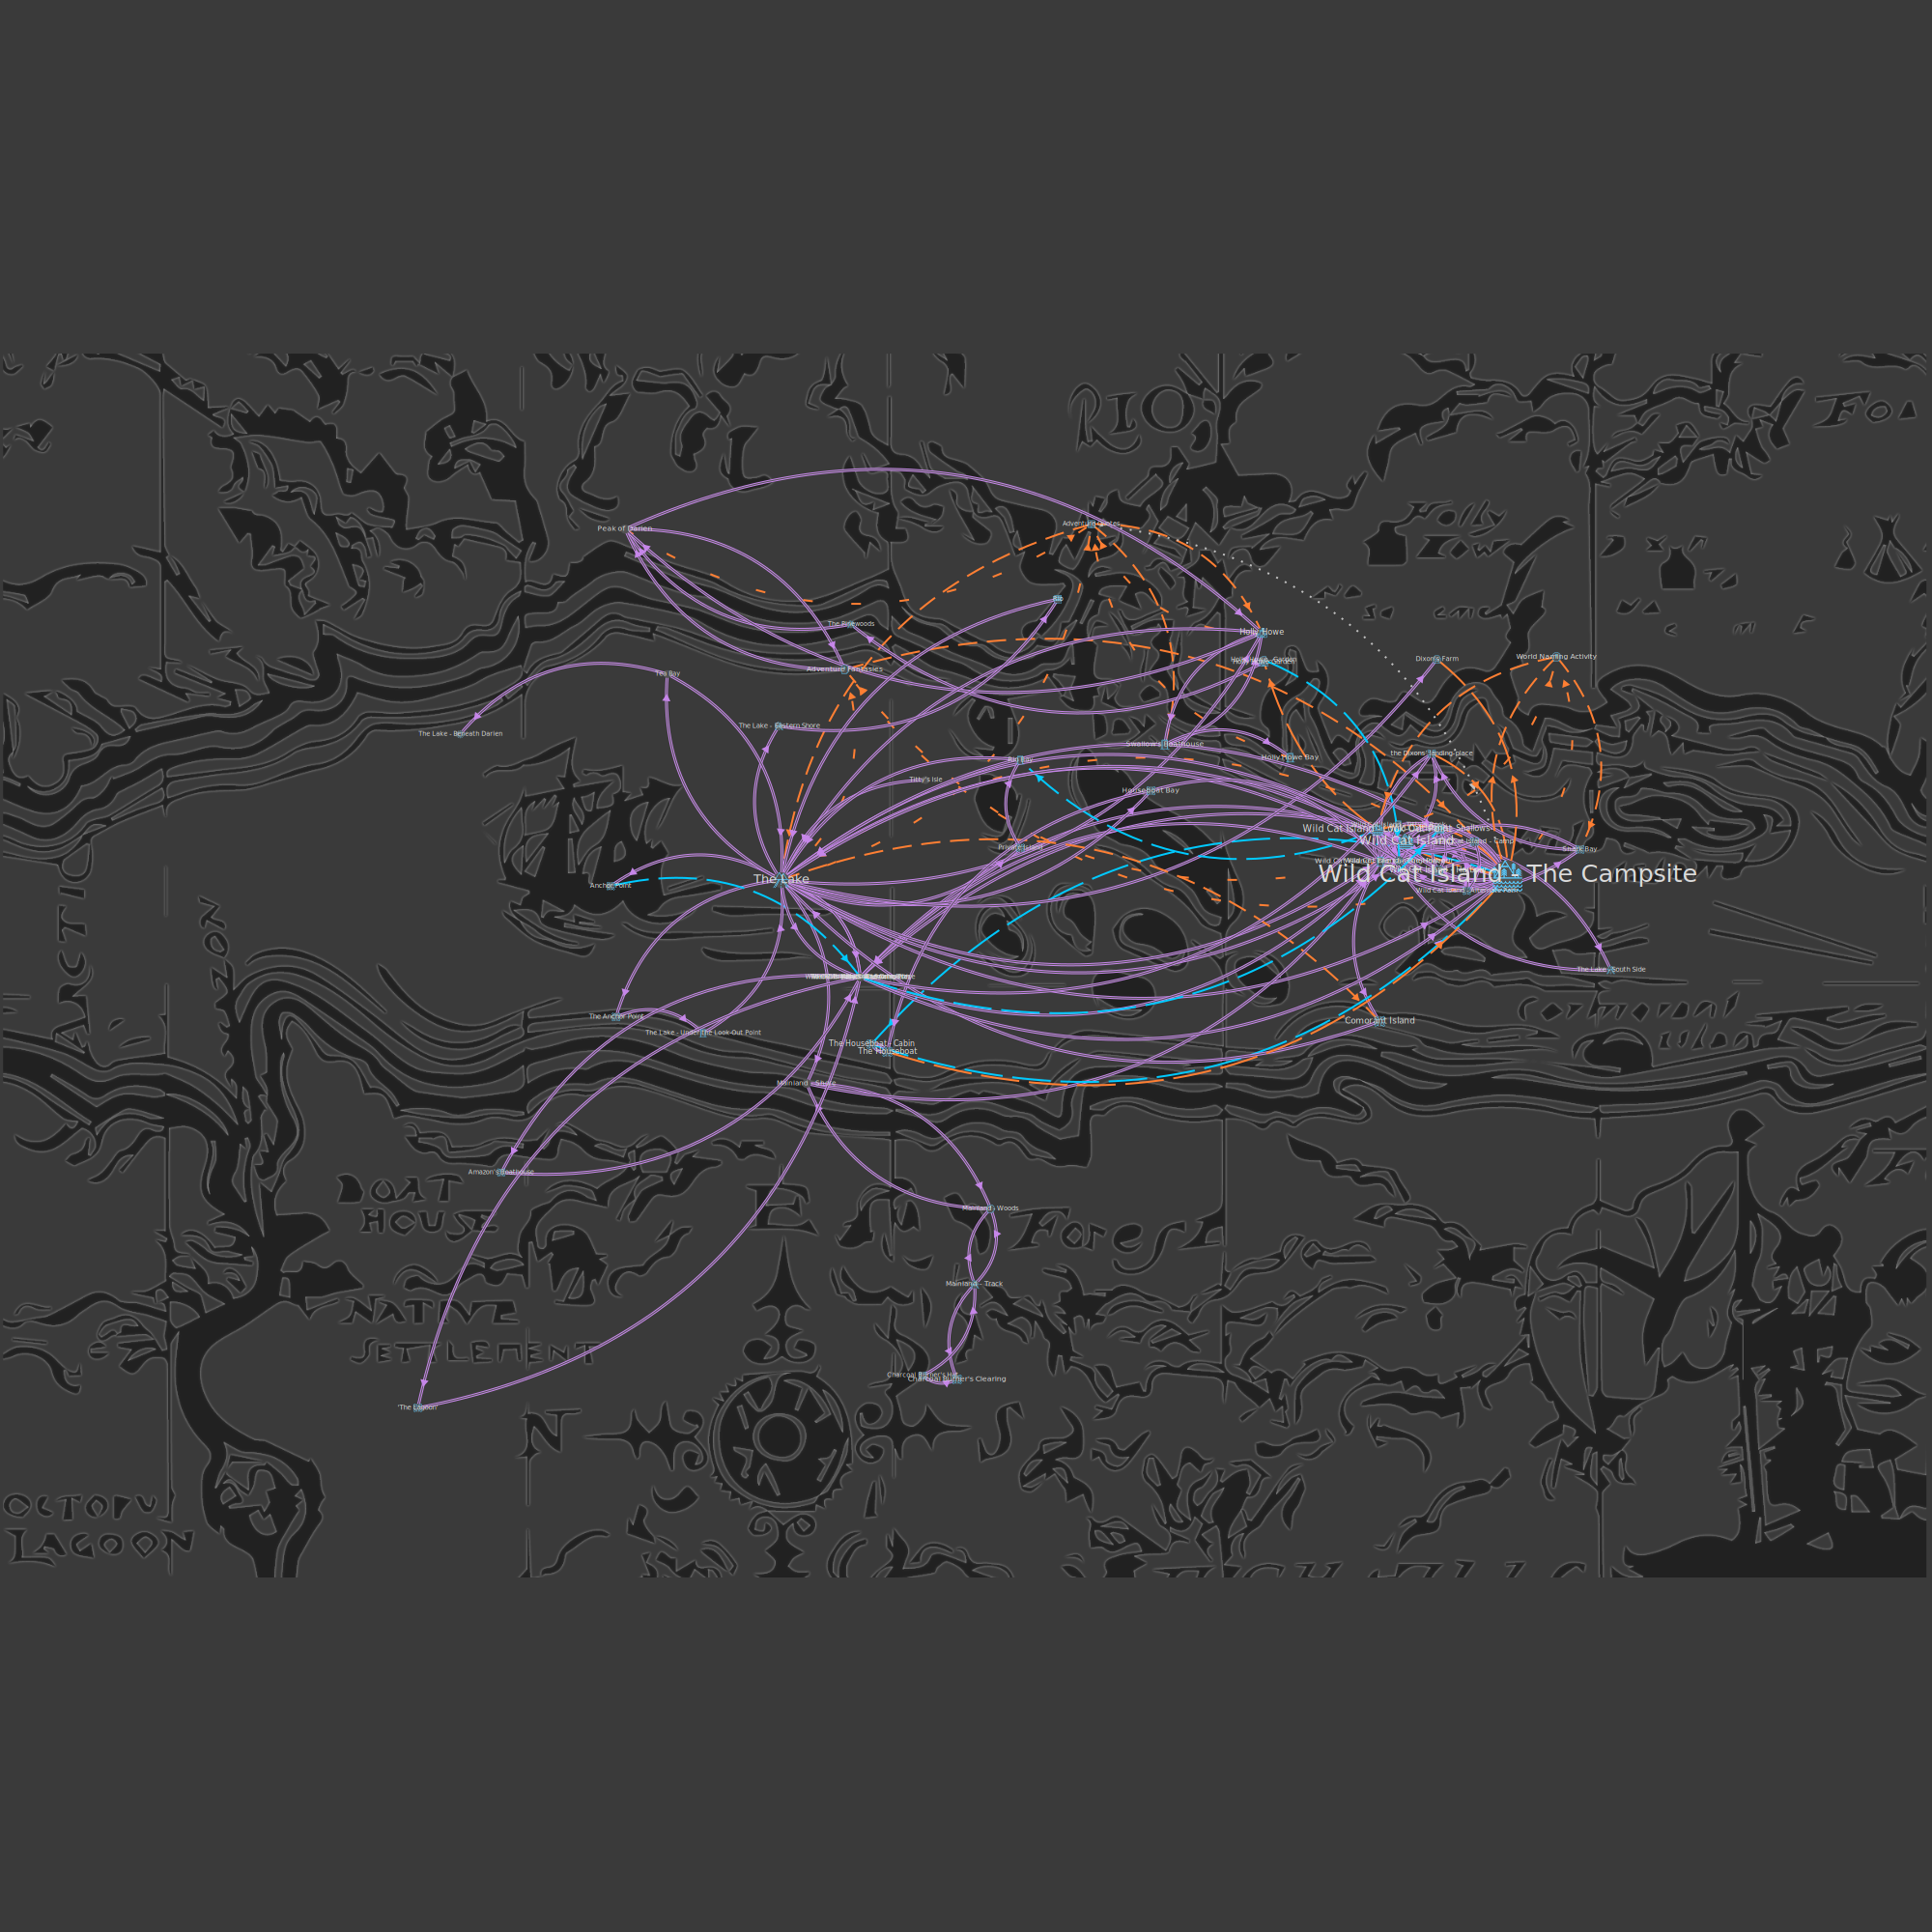

In [10]:
graphml_file = 's&a-laid-out-2.graphml'

svg_file = graphml_file.replace('graphml', 'svg')

visualisation = SvgGrapher('files/graphs/' + graphml_file)

visualisation.draw_graph('files/svg/' + svg_file, style=colour_style, size=1, scale_correction=370, curved=True, label_correction=0.8, node_scale=0.8, offset=(0,0))

# Display the graph
display_svg(SVG('files/svg/' + svg_file))